In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pkg_resources
import matplotlib.pyplot as plt
import numpy as np
import pprint
from pathlib import Path
from tqdm import trange

import flygym.util.vision as vision
from flygym.arena.mujoco_arena import GappedTerrain
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from flygym.util.config import all_leg_dofs

from arena import ObstacleOdorArena

pygame 2.5.1 (SDL 2.28.2, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
run_time = 1
timestep = 1e-4
actuated_joints = all_leg_dofs

# Load recorded data
data_path = Path(pkg_resources.resource_filename("flygym", "data"))
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

# Interpolate 5x
num_steps = int(run_time / timestep)
data_block = np.zeros((len(actuated_joints), num_steps))
measure_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
interp_t = np.arange(num_steps) * timestep
for i, joint in enumerate(actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [4]:
def sample_visual_data(
    nmf, obstacle_positions, action, visualize=False, camera="birdeye_cam_origin"
):
    # Change obstacle positions in the arena
    for i in range(obstacle_positions.shape[0]):
        pos_xyz = np.array([*obstacle_positions[i, :], nmf.arena.obstacle_z_pos])
        nmf.physics.bind(nmf.arena.obstacle_bodies[i]).mocap_pos = pos_xyz
    nmf.step(action)

    # Render visual input
    nmf._last_vision_update_time = -np.inf  # hack: this forces visual input update
    nmf._update_vision()
    visual_input = nmf.curr_visual_input.copy()
    raw_cam_imgs = nmf.curr_raw_visual_input.copy()

    # Calculate obstacle positions relative to the fly
    fly_rotation = nmf.get_observation()["fly"][2, 0] - np.pi / 2
    rot_matrix = np.array(
        [
            [np.cos(fly_rotation), -np.sin(fly_rotation)],
            [np.sin(fly_rotation), np.cos(fly_rotation)],
        ]
    )
    obstacle_positions_transformed = obstacle_positions - nmf.spawn_pos[:2]
    obstacle_positions_transformed[:, 1] *= -1  # change y to right-hand-positive
    obstacle_positions_transformed = (rot_matrix @ obstacle_positions_transformed.T).T

    # Visualize
    if visualize:
        fig, axs = plt.subplots(1, 5, figsize=(10, 5), tight_layout=True)
        birdeye_img = nmf.physics.render(camera_id=camera, height=512, width=512)
        axs[0].imshow(birdeye_img)
        axs[0].axis("off")
        for i in range(2):
            axs[i + 1].imshow(raw_cam_imgs[i], cmap="gray", vmin=0, vmax=255)
            axs[i + 1].axis("off")
        for i in range(2):
            vis = vision.hex_pxls_to_human_readable(
                visual_input[i], vision.ommatidia_id_map
            )
            axs[i + 3].imshow(vis, cmap="gray", vmin=0, vmax=255)
            axs[i + 3].axis("off")

    return visual_input, obstacle_positions_transformed

  0%|          | 0/3 [00:00<?, ?it/s]/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


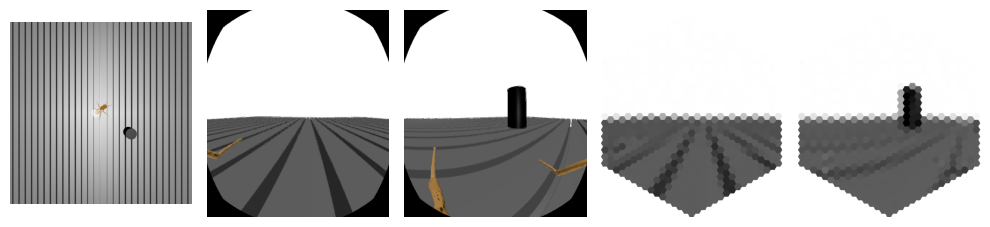

{'fly_heading': 2.1805890680411517,
 'fly_pos': array([0.21210226, 0.88372616]),
 'fly_state_idx': 0,
 'obstacle_dir': -0.7264511579796973,
 'obstacle_dist': 6.988509574287779,
 'obstacle_pos': array([ 5.43626699, -3.75818821]),
 'obstacle_position_rel': array([[1.65307884, 6.7875037 ]]),
 'obstacle_state_idx': 0,
 'visual_input': array([[[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 68.5       ,   0.        ],
        [  0.        ,  92.        ],
        [ 92.        ,   0.        ]],

       [[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 92.78448276,   0.        ],
        [  0.        ,  92.78099174],
        [ 94.32758621,   0.        ]]])}


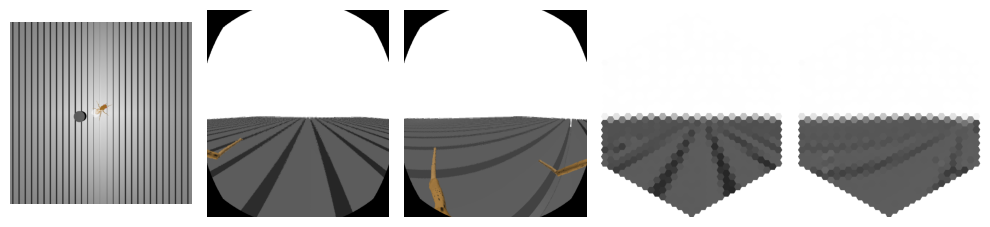

 33%|███▎      | 1/3 [00:05<00:10,  5.08s/it]

{'fly_heading': 2.1803047725277915,
 'fly_pos': array([0.21200157, 0.88452157]),
 'fly_state_idx': 0,
 'obstacle_dir': -2.785254507782425,
 'obstacle_dist': 4.380276852355778,
 'obstacle_pos': array([-3.89310858, -0.64351507]),
 'obstacle_position_rel': array([[-4.21359762, -1.10595646]]),
 'obstacle_state_idx': 1,
 'visual_input': array([[[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 69.26293103,   0.        ],
        [  0.        ,  92.        ],
        [ 92.        ,   0.        ]],

       [[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 92.77586207,   0.        ],
        [  0.        ,  92.67768595],
        [ 94.15517241,   0.        ]]])}


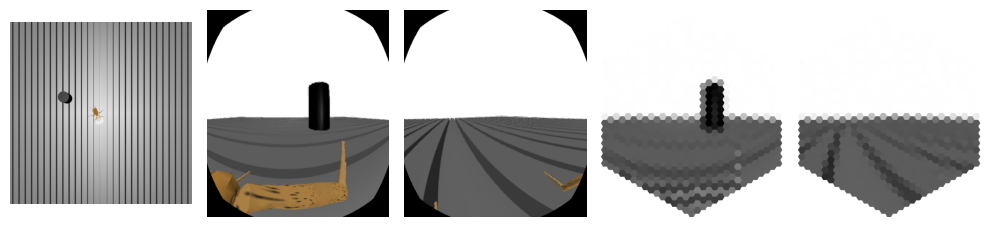

{'fly_heading': -2.745662624597,
 'fly_pos': array([-0.90096243, -0.06005792]),
 'fly_state_idx': 1,
 'obstacle_dir': 2.6741025445054722,
 'obstacle_dist': 6.5443564887514585,
 'obstacle_pos': array([-6.74312369,  2.8891375 ]),
 'obstacle_position_rel': array([[ 5.00282882, -4.2279611 ]]),
 'obstacle_state_idx': 0,
 'visual_input': array([[[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 94.0862069 ,   0.        ],
        [  0.        ,  96.26446281],
        [ 98.35344828,   0.        ]],

       [[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 75.99568966,   0.        ],
        [  0.        ,  92.        ],
        [ 92.        ,   0.        ]]])}


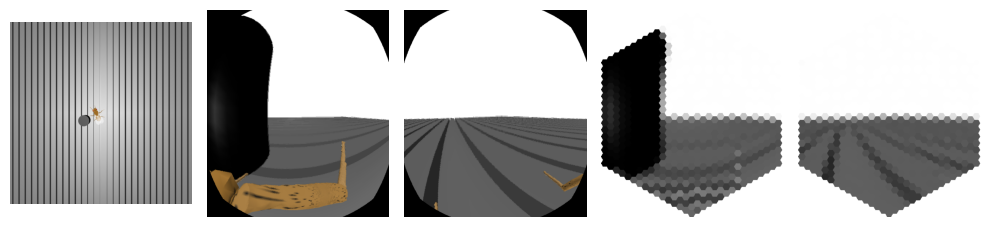

 67%|██████▋   | 2/3 [00:07<00:03,  3.61s/it]

{'fly_heading': -2.7445066494645447,
 'fly_pos': array([-0.90101191, -0.06005329]),
 'fly_state_idx': 1,
 'obstacle_dir': -2.594143117880226,
 'obstacle_dist': 2.5682884655830955,
 'obstacle_pos': array([-3.09395745, -1.3968762 ]),
 'obstacle_position_rel': array([[-0.35808907, -2.52067959]]),
 'obstacle_state_idx': 1,
 'visual_input': array([[[6.89655172e-02, 0.00000000e+00],
        [0.00000000e+00, 8.09128631e-01],
        [2.65948276e+00, 0.00000000e+00],
        ...,
        [9.40948276e+01, 0.00000000e+00],
        [0.00000000e+00, 9.62644628e+01],
        [9.83146552e+01, 0.00000000e+00]],

       [[2.52801724e+02, 0.00000000e+00],
        [0.00000000e+00, 2.55000000e+02],
        [2.55000000e+02, 0.00000000e+00],
        ...,
        [7.60646552e+01, 0.00000000e+00],
        [0.00000000e+00, 9.20000000e+01],
        [9.19267241e+01, 0.00000000e+00]]])}


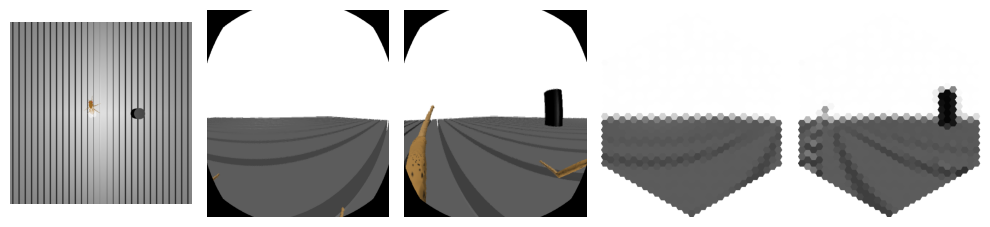

{'fly_heading': -3.0101503027712893,
 'fly_pos': array([-1.92022514,  1.36001337]),
 'fly_state_idx': 2,
 'obstacle_dir': -0.16582554216397138,
 'obstacle_dist': 8.96069806686749,
 'obstacle_pos': array([ 6.91755386, -0.11909863]),
 'obstacle_position_rel': array([[-2.58652686,  8.57310174]]),
 'obstacle_state_idx': 0,
 'visual_input': array([[[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 91.48275862,   0.        ],
        [  0.        ,  92.        ],
        [ 92.        ,   0.        ]],

       [[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 81.57327586,   0.        ],
        [  0.        ,  91.85950413],
        [ 92.22413793,   0.        ]]])}


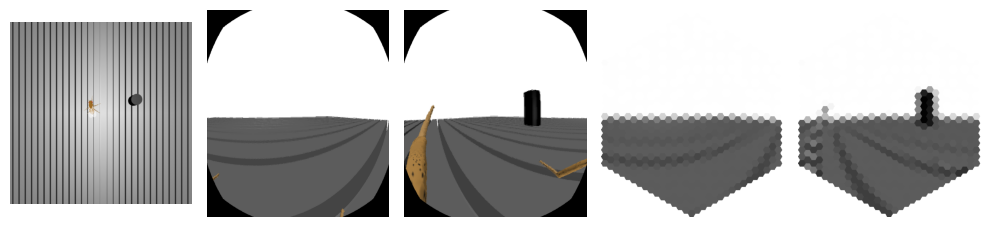

100%|██████████| 3/3 [00:10<00:00,  3.40s/it]

{'fly_heading': -3.0111675064853927,
 'fly_pos': array([-1.92057589,  1.36023747]),
 'fly_state_idx': 2,
 'obstacle_dir': 0.12866379864420052,
 'obstacle_dist': 8.407286015837155,
 'obstacle_pos': array([6.4172174 , 2.43896878]),
 'obstacle_position_rel': array([[0.0233882 , 8.40968667]]),
 'obstacle_state_idx': 1,
 'visual_input': array([[[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 91.56034483,   0.        ],
        [  0.        ,  92.        ],
        [ 92.        ,   0.        ]],

       [[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 81.43965517,   0.        ],
        [  0.        ,  91.78512397],
        [ 92.21982759,   0.        ]]])}


In [5]:
fly_pos_range = [-2, 2]
fly_heading_range = [-np.pi, np.pi]
obs_dist_range = [2, 10]
obs_dir_range = [-np.pi, np.pi]
fly_pos_idx_range = [0, data_block.shape[1] - 1]
num_fly_state_samples = 3
num_obstacle_state_samples_per_fly_state = 2
debug = True

res_all = []

np.random.seed(0)

for i in trange(num_fly_state_samples):
    terrain_arena = GappedTerrain(
        x_range=(-20, 20), y_range=(-20, 20), gap_width=0.25, ground_alpha=1
    )
    arena = ObstacleOdorArena(
        terrain=terrain_arena,
        obstacle_positions=np.array([[10, 0]]),
        marker_size=0.5,
        obstacle_colors=(0, 0, 0, 1),
        user_camera_settings=((16, -30, 11), (np.deg2rad(75), 0, 0), 30),
    )
    sim_params = MuJoCoParameters(
        render_playspeed=0.2,
        render_camera="user_cam",
        enable_vision=True,
        render_raw_vision=True,
        enable_olfaction=True,
    )
    nmf = NeuroMechFlyMuJoCo(
        sim_params=sim_params,
        arena=arena,
        spawn_pos=(*np.random.uniform(*fly_pos_range, size=(2,)), 0.2),
        spawn_orient=(0, 0, np.pi / 2 + np.random.uniform(*fly_heading_range)),
    )
    action = {"joints": data_block[:, np.random.randint(*fly_pos_idx_range)]}
    for _ in range(50):
        nmf.step(action)

    num_obs_states_sampled = 0
    while num_obs_states_sampled < num_obstacle_state_samples_per_fly_state:
        fly_pos = nmf.get_observation()["fly"][0, :2]
        fly_heading = nmf.get_observation()["fly"][2, 0]
        obs_dist = np.random.uniform(*obs_dist_range)
        obs_dir = np.random.uniform(*obs_dir_range)
        obs_dx = obs_dist * np.cos(obs_dir)
        obs_xy = obs_dist * np.sin(obs_dir)
        obstacle_position = np.array([obs_dx, obs_xy]) + fly_pos
        visual_input, obstacle_positions_transformed = sample_visual_data(
            nmf,
            obstacle_position.reshape(1, -1),
            action=action,
            visualize=debug,
        )
        entry = {
            "fly_state_idx": i,
            "obstacle_state_idx": num_obs_states_sampled,
            "visual_input": visual_input,
            "obstacle_position_rel": obstacle_positions_transformed,
            "fly_pos": fly_pos,
            "obstacle_pos": obstacle_position,
            "fly_heading": fly_heading,
            "obstacle_dist": obs_dist,
            "obstacle_dir": obs_dir,
        }
        res_all.append(entry)
        num_obs_states_sampled += 1
        if debug:
            plt.show()
            pprint.pprint(entry)
        

In [6]:
fly_pos_range = [-2, 2]
fly_heading_range = [-np.pi, np.pi]
obs_dist_range = [0, 10]
obs_dir_range = [-np.pi, np.pi]
fly_pos_idx_range = [0, data_block.shape[1] - 1]
num_fly_state_samples = 1000
num_obstacle_state_samples_per_fly_state = 10
debug = False

res_all = []

np.random.seed(0)

for i in trange(num_fly_state_samples):
    terrain_arena = GappedTerrain(
        x_range=(-20, 20), y_range=(-20, 20), gap_width=0.25, ground_alpha=1
    )
    arena = ObstacleOdorArena(
        terrain=terrain_arena,
        obstacle_positions=np.array([[10, 0]]),
        marker_size=0.5,
        obstacle_colors=(0, 0, 0, 1),
        user_camera_settings=((16, -30, 11), (np.deg2rad(75), 0, 0), 30),
    )
    sim_params = MuJoCoParameters(
        render_playspeed=0.2,
        render_camera="user_cam",
        enable_vision=True,
        render_raw_vision=True,
        enable_olfaction=True,
    )
    nmf = NeuroMechFlyMuJoCo(
        sim_params=sim_params,
        arena=arena,
        spawn_pos=(*np.random.uniform(*fly_pos_range, size=(2,)), 0.2),
        spawn_orient=(0, 0, np.pi / 2 + np.random.uniform(*fly_heading_range)),
    )
    action = {"joints": data_block[:, np.random.randint(*fly_pos_idx_range)]}
    for _ in range(50):
        nmf.step(action)

    num_obs_states_sampled = 0
    while num_obs_states_sampled < num_obstacle_state_samples_per_fly_state:
        fly_pos = nmf.get_observation()["fly"][0, :2]
        fly_heading = nmf.get_observation()["fly"][2, 0]
        obs_dist = np.random.uniform(*obs_dist_range)
        obs_dir = np.random.uniform(*obs_dir_range)
        obs_dx = obs_dist * np.cos(obs_dir)
        obs_xy = obs_dist * np.sin(obs_dir)
        obstacle_position = np.array([obs_dx, obs_xy]) + fly_pos
        visual_input, obstacle_positions_transformed = sample_visual_data(
            nmf,
            obstacle_position.reshape(1, -1),
            action=action,
            visualize=debug,
        )
        entry = {
            "fly_state_idx": i,
            "obstacle_state_idx": num_obs_states_sampled,
            "visual_input": visual_input,
            "obstacle_position_rel": obstacle_positions_transformed[0],
            "fly_pos": fly_pos,
            "obstacle_pos": obstacle_position,
            "fly_heading": fly_heading,
            "obstacle_dist": obs_dist,
            "obstacle_dir": obs_dir,
        }
        res_all.append(entry)
        num_obs_states_sampled += 1
        if debug:
            plt.show()
            pprint.pprint(entry)
        

100%|██████████| 1000/1000 [42:55<00:00,  2.58s/it]


In [7]:
with open("data/visual_training_data.pkl", "wb") as f:
    pickle.dump(res_all, f)